In [1]:
################################################################
''' Preporcessing steps: 
1. lowercasing 
2. Digit -> DDD 
3. URLs -> httpAddress 
4. @username -> userID 
5. Remove special characters, keep ; . ! ? 
6. normalize elongation 
7. tokenization using tweetNLP
output is ~/Dropbox (QCRI)/AIDR-DA-ALT-SC/data/labeled datasets/prccd_data/{filename}_AIDR_prccd.csv
'''
#################################################################

#=================
#==> Libraries <==
#=================
import re, os
import string 
import sys
import twokenize
import csv
import pandas as pd
from collections import defaultdict
from os.path import basename
import ntpath
import codecs
import unicodedata

def process(lst):
    prccd_item_list=[]
    for tweet in lst:


#         # Normalizing utf8 formatting
#         tweet = tweet.decode("unicode-escape").encode("utf8").decode("utf8")
#         #tweet = tweet.encode("utf-8")
#         tweet = tweet.encode("ascii","ignore")
#         tweet = tweet.strip(' \t\n\r')

        # 1. Lowercasing
        tweet = tweet.lower()
        #print "[lowercase]", tweet

        # Word-Level
        tweet = re.sub(' +',' ',tweet) # replace multiple spaces with a single space

        # 2. Normalizing digits
        tweet_words = tweet.strip('\r').split(' ')
        for word in [word for word in tweet_words if word.isdigit()]:
            tweet = tweet.replace(word, "D" * len(word))
#         print( "[digits]", tweet)

        # 3. Normalizing URLs
        tweet_words = tweet.strip('\r').split(' ')
        for word in [word for word in tweet_words if '/' in word or '.' in word and  len(word) > 3]:
            tweet = tweet.replace(word, "")
#         print( "[URLs]", tweet)

        #4. Normalizing username

        tweet_words = tweet.strip('\r').split(' ')
        try:
            for word in [word for word in tweet_words if word[0] == '@' and len(word) > 1]:
                tweet = tweet.replace(word, "")
#         print( "[usrename]", tweet)
        except:
            tweet = tweet


        # 5. Removing special Characters
        punc = '@$%^&*()_+-={}[]:"|\'\~`<>/,'
        trans = str.maketrans(punc, ' '*len(punc))
        tweet = tweet.translate(trans)
        #print( "[punc]", tweet)

        # 6. Normalizing +2 elongated char
        tweet = re.sub(r"(.)\1\1+",r'\1\1', tweet)
        #print ("[elong]", tweet)

        # 7. tokenization using tweetNLP
        tweet = ' '.join(twokenize.simpleTokenize(tweet))
        #print( "[token]", tweet )

        #8. fix \n char
        tweet = tweet.replace('\n', ' ')

        prccd_item_list.append(tweet.strip())
#         print ("[processed]", tweet.replace('\n', ' '))
        
    return prccd_item_list

code_dir = os.getcwd()
parent_dir = os.path.dirname(code_dir)
print(parent_dir)
labled_data_folder  =  os.path.join(parent_dir,"Data/crisis_datasets_benchmarks/all_data_en")
initial_filtering_folder = os.path.join(parent_dir,"Data/crisis_datasets_benchmarks/initial_filtering")


train = pd.read_table(os.path.join
                       (labled_data_folder,
                                    "crisis_consolidated_informativeness_filtered_lang_en_train.tsv"))
test = pd.read_table(os.path.join
                       (labled_data_folder,
                                    "crisis_consolidated_informativeness_filtered_lang_en_test.tsv"),
                       sep ='\t', quoting =3)
dev = pd.read_table(os.path.join
                     (labled_data_folder,
                                  "crisis_consolidated_informativeness_filtered_lang_en_dev.tsv"))
combinedf = pd.concat([train,test,dev])
df_list = [combinedf,train, test, dev]
df_list_name = ['combinedf','train', 'test', 'dev']
proc_list = []
for i, df in enumerate(df_list):
    print("processing: "+df_list_name[i])
    df['processed_txt'] = process(df['text'])
    print("processing: "+df_list_name[i] + " complete")

/Volumes/Elements/DataScience/dsa/capstone
processing: combinedf
processing: combinedf complete
processing: train
processing: train complete
processing: test
processing: test complete
processing: dev
processing: dev complete


In [2]:
%matplotlib inline


# Classification of text documents using sparse features

This is an example showing how scikit-learn can be used to classify documents
by topics using a bag-of-words approach. This example uses a scipy.sparse
matrix to store the features and demonstrates various classifiers that can
efficiently handle sparse matrices.

The dataset used in this example is the 20 newsgroups dataset. It will be
automatically downloaded, then cached.


In [3]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Olivier Grisel <olivier.grisel@ensta.org>
#         Mathieu Blondel <mathieu@mblondel.org>
#         Lars Buitinck
# License: BSD 3 clause
import logging
import numpy as np
from optparse import OptionParser
import sys
from time import time
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.extmath import density
from sklearn import metrics


# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

op = OptionParser()
op.add_option("--report",
              action="store_true", dest="print_report",
              help="Print a detailed classification report.")
op.add_option("--chi2_select",
              action="store", type="int", dest="select_chi2",
              help="Select some number of features using a chi-squared test")
op.add_option("--confusion_matrix",
              action="store_true", dest="print_cm",
              help="Print the confusion matrix.")
op.add_option("--top10",
              action="store_true", dest="print_top10",
              help="Print ten most discriminative terms per class"
                   " for every classifier.")
op.add_option("--all_categories",
              action="store_true", dest="all_categories",
              help="Whether to use all categories or not.")
op.add_option("--use_hashing",
              action="store_true",
              help="Use a hashing vectorizer.")
op.add_option("--n_features",
              action="store", type=int, default=2 ** 16,
              help="n_features when using the hashing vectorizer.")
op.add_option("--filtered",
              action="store_true",
              help="Remove newsgroup information that is easily overfit: "
                   "headers, signatures, and quoting.")


def is_interactive():
    return not hasattr(sys.modules['__main__'], '__file__')


# work-around for Jupyter notebook and IPython console
argv = [] if is_interactive() else sys.argv[1:]
(opts, args) = op.parse_args(argv)
if len(args) > 0:
    op.error("this script takes no arguments.")
    sys.exit(1)

print(__doc__)
op.print_help()
print()

 Preporcessing steps: 
1. lowercasing 
2. Digit -> DDD 
3. URLs -> httpAddress 
4. @username -> userID 
5. Remove special characters, keep ; . ! ? 
6. normalize elongation 
7. tokenization using tweetNLP
output is ~/Dropbox (QCRI)/AIDR-DA-ALT-SC/data/labeled datasets/prccd_data/{filename}_AIDR_prccd.csv

Usage: ipykernel_launcher.py [options]

Options:
  -h, --help            show this help message and exit
  --report              Print a detailed classification report.
  --chi2_select=SELECT_CHI2
                        Select some number of features using a chi-squared
                        test
  --confusion_matrix    Print the confusion matrix.
  --top10               Print ten most discriminative terms per class for
                        every classifier.
  --all_categories      Whether to use all categories or not.
  --use_hashing         Use a hashing vectorizer.
  --n_features=N_FEATURES
                        n_features when using the hashing vectorizer.
  --filtered     

## Load data from the training set
Let's load data from the newsgroups dataset which comprises around 18000
newsgroups posts on 20 topics split in two subsets: one for training (or
development) and the other one for testing (or for performance evaluation).



In [7]:
# if opts.all_categories:
#     categories = None
# else:
#     categories = [
#         'alt.atheism',
#         'talk.religion.misc',
#         'comp.graphics',
#         'sci.space',
#     ]

# if opts.filtered:
#     remove = ('headers', 'footers', 'quotes')
# else:
#     remove = ()

# print("Loading 20 newsgroups dataset for categories:")
# print(categories if categories else "all")

data_train = df_list[1]

data_test = df_list[2]
print('data loaded')

# order of labels in `target_names` can be different from `categories`
target_names = data_train.class_label.unique()


def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs) / 1e6


data_train_size_mb = size_mb(data_train.processed_txt)
data_test_size_mb = size_mb(data_test.processed_txt)

print("%d documents - %0.3fMB (training set)" % (
    len(data_train.processed_txt), data_train_size_mb))
print("%d documents - %0.3fMB (test set)" % (
    len(data_test.processed_txt), data_test_size_mb))
print("%d categories" % len(target_names))
print()

# split a training set and a test set
y_train, y_test = data_train.class_label, data_test.class_label

print("Extracting features from the training data using a sparse vectorizer")
t0 = time()
if opts.use_hashing:
    vectorizer = HashingVectorizer(stop_words='english', alternate_sign=False,
                                   n_features=opts.n_features)
    X_train = vectorizer.transform(data_train.processed_txt)
else:
    vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5,
                                 stop_words='english')
    X_train = vectorizer.fit_transform(data_train.processed_txt)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_train_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_train.shape)
print()

print("Extracting features from the test data using the same vectorizer")
t0 = time()
X_test = vectorizer.transform(data_test.processed_txt)
duration = time() - t0
print("done in %fs at %0.3fMB/s" % (duration, data_test_size_mb / duration))
print("n_samples: %d, n_features: %d" % X_test.shape)
print()

# mapping from integer feature name to original token string
if opts.use_hashing:
    feature_names = None
else:
    feature_names = vectorizer.get_feature_names()

if opts.select_chi2:
    print("Extracting %d best features by a chi-squared test" %
          opts.select_chi2)
    t0 = time()
    ch2 = SelectKBest(chi2, k=opts.select_chi2)
    X_train = ch2.fit_transform(X_train, y_train)
    X_test = ch2.transform(X_test)
    if feature_names:
        # keep selected feature names
        feature_names = [feature_names[i] for i
                         in ch2.get_support(indices=True)]
    print("done in %fs" % (time() - t0))
    print()

if feature_names:
    feature_names = np.asarray(feature_names)


def trim(s):
    """Trim string to fit on terminal (assuming 80-column display)"""
    return s if len(s) <= 80 else s[:77] + "..."

data loaded
109441 documents - 9.391MB (training set)
31095 documents - 2.662MB (test set)
2 categories

Extracting features from the training data using a sparse vectorizer
done in 1.641157s at 5.722MB/s
n_samples: 109441, n_features: 92634

Extracting features from the test data using the same vectorizer
done in 0.385138s at 6.912MB/s
n_samples: 31095, n_features: 92634



## Benchmark classifiers
We train and test the datasets with 15 different classification models
and get performance results for each model.



In [8]:
def benchmark(clf):
    print('_' * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print("train time: %0.3fs" % train_time)

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print("test time:  %0.3fs" % test_time)

    score = metrics.accuracy_score(y_test, pred)
    print("accuracy:   %0.3f" % score)

    if hasattr(clf, 'coef_'):
        print("dimensionality: %d" % clf.coef_.shape[1])
        print("density: %f" % density(clf.coef_))

        if opts.print_top10 and feature_names is not None:
            print("top 10 keywords per class:")
            for i, label in enumerate(target_names):
                top10 = np.argsort(clf.coef_[i])[-10:]
                print(trim("%s: %s" % (label, " ".join(feature_names[top10]))))
        print()

    if opts.print_report:
        print("classification report:")
        print(metrics.classification_report(y_test, pred,
                                            target_names=target_names))

    if opts.print_cm:
        print("confusion matrix:")
        print(metrics.confusion_matrix(y_test, pred))

    print()
    clf_descr = str(clf).split('(')[0]
    return clf_descr, score, train_time, test_time


results = []
for clf, name in (
        (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
        (Perceptron(max_iter=50), "Perceptron"),
        (PassiveAggressiveClassifier(max_iter=50),
         "Passive-Aggressive"),
        (KNeighborsClassifier(n_neighbors=10), "kNN"),
        (RandomForestClassifier(), "Random forest")):
    print('=' * 80)
    print(name)
    results.append(benchmark(clf))

for penalty in ["l2", "l1"]:
    print('=' * 80)
    print("%s penalty" % penalty.upper())
    # Train Liblinear model
    results.append(benchmark(LinearSVC(penalty=penalty, dual=False,
                                       tol=1e-3)))

    # Train SGD model
    results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                           penalty=penalty)))

# Train SGD with Elastic Net penalty
print('=' * 80)
print("Elastic-Net penalty")
results.append(benchmark(SGDClassifier(alpha=.0001, max_iter=50,
                                       penalty="elasticnet")))

# Train NearestCentroid without threshold
print('=' * 80)
print("NearestCentroid (aka Rocchio classifier)")
results.append(benchmark(NearestCentroid()))

# Train sparse Naive Bayes classifiers
print('=' * 80)
print("Naive Bayes")
results.append(benchmark(MultinomialNB(alpha=.01)))
results.append(benchmark(BernoulliNB(alpha=.01)))
results.append(benchmark(ComplementNB(alpha=.1)))

print('=' * 80)
print("LinearSVC with L1-based feature selection")
# The smaller C, the stronger the regularization.
# The more regularization, the more sparsity.
results.append(benchmark(Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False,
                                                  tol=1e-3))),
  ('classification', LinearSVC(penalty="l2"))])))

Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(solver='sag', tol=0.01)


/Volumes/Elements/DataScience/anaconda3/envs/machinelearning/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:555: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


train time: 1.564s
test time:  0.002s
accuracy:   0.847
dimensionality: 92634
density: 1.000000


Perceptron
________________________________________________________________________________
Training: 
Perceptron(max_iter=50)
train time: 0.417s
test time:  0.002s
accuracy:   0.796
dimensionality: 92634
density: 0.650593


Passive-Aggressive
________________________________________________________________________________
Training: 
PassiveAggressiveClassifier(max_iter=50)
train time: 0.738s
test time:  0.003s
accuracy:   0.807
dimensionality: 92634
density: 0.831585


kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=10)
train time: 0.107s
test time:  69.874s
accuracy:   0.463

Random forest
________________________________________________________________________________
Training: 
RandomForestClassifier()
train time: 535.280s
test time:  6.891s
accuracy:   0.851

L2 penalty
___________________________________

/Volumes/Elements/DataScience/anaconda3/envs/machinelearning/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


train time: 0.359s
test time:  0.119s
accuracy:   0.814
dimensionality: 92634
density: 1.000000




/Volumes/Elements/DataScience/anaconda3/envs/machinelearning/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


________________________________________________________________________________
Training: 
ComplementNB(alpha=0.1)
train time: 0.319s
test time:  0.003s
accuracy:   0.809
dimensionality: 92634
density: 1.000000


LinearSVC with L1-based feature selection
________________________________________________________________________________
Training: 
Pipeline(steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(dual=False, penalty='l1',
                                                     tol=0.001))),
                ('classification', LinearSVC())])


/Volumes/Elements/DataScience/anaconda3/envs/machinelearning/lib/python3.8/site-packages/sklearn/utils/deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)


train time: 2.689s
test time:  0.006s
accuracy:   0.847



## Add plots
The bar plot indicates the accuracy, training time (normalized) and test time
(normalized) of each classifier.



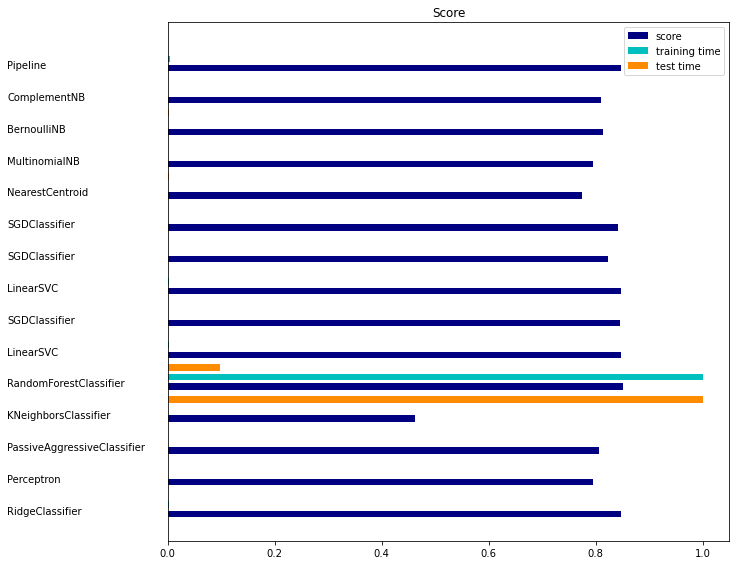

In [9]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time) / np.max(training_time)
test_time = np.array(test_time) / np.max(test_time)

plt.figure(figsize=(12, 8))
plt.title("Score")
plt.barh(indices, score, .2, label="score", color='navy')
plt.barh(indices + .3, training_time, .2, label="training time",
         color='c')
plt.barh(indices + .6, test_time, .2, label="test time", color='darkorange')
plt.yticks(())
plt.legend(loc='best')
plt.subplots_adjust(left=.25)
plt.subplots_adjust(top=.95)
plt.subplots_adjust(bottom=.05)

for i, c in zip(indices, clf_names):
    plt.text(-.3, i, c)

plt.show()